# Project 3 - Inference

Welcome to the third and final project in Data 8!  You will investigate the relationship between murder and capital punishment (the death penalty) in the United States.  By the end of the project, you should know how to:

1. Test whether observed data appears to be a random sample from a distribution
2. Analyze a natural experiment
3. Implement and interpret a sign test

**Run the cell below** to prepare the automatic tests. **Passing the automatic tests does not guarantee full credit on any question.** The tests are provided to help catch some common errors, but it is your responsibility to answer the questions correctly.

In [2]:
# Run this cell, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib

matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# These lines load the tests.
from client.api.assignment import load_assignment 
project3 = load_assignment('project3.ok')

Assignment: Project 3
OK, version v1.5.1



# 1. Murder rates
Punishment for crime has many [philosophical justifications](http://plato.stanford.edu/entries/punishment/#ThePun).  An important one, of course, is that fear of punishment may *deter* people from committing crimes.  Deterrence has been a focal point of the debate over the death penalty in the United States.  Does instituting a death penalty for murder actually reduce the number of murders?  You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  We'll try to answer this question using data.

The main data source for this project comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled their data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, when we're looking at state-level data, we need to account for the number of people in each state.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

In [3]:
murder_rates = Table.read_table('crime_rates.csv').select(['State', 'Year', 'Population', 'Murder Rate'])
murder_rates.set_format(2, NumberFormatter)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


So far, this looks like a dataset that lends itself to an observational study.  In fact, these data aren't even enough to demonstrate an *association* between the existence of the death penalty in a state in a year and the murder rate in that state and year!

**Question 1.1.** What additional information will we need before we can check for that association?

*Write your answer here, replacing this text.*

Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot a couple, just to see the variety.

**Question 1.2.** Draw a line plot with years on the horizontal axis and murder rates on the 
vertical axis. Include two lines: one for Alaska murder rates and one for Minnesota murder rates. Create this plot using a single call, `ak_mn.plot('Year')`.

*Hint*: To create two lines, you will need two columns of murder rates, in addition to a column of years. You can use `join` to create this table, which will have the following structure:

| Year | Alaska | Minnesota |
|------|--------|-----------|
| 1960 | 10.2   | 1.2       |
| 1961 | 11.5   | 1         |
| 1962 | 4.5    | 0.9       |

In [4]:
ak = murder_rates.where('State', 'Alaska').drop(['State', 'Population']).relabeled(1, 'Alaska')
mn = murder_rates.where('State', 'Minnesota').drop(['State', 'Population']).relabeled(1, 'Minnesota')
# Fill in this line to make a table like the one pictured above.
ak_mn = Table().with_columns([
        "Year", ak.column("Year"),
        "Alaska", ak.column("Alaska"),
        "Minnesota", mn.column("Minnesota")
    ])


In [5]:
_ = project3.grade("q12")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 1.3.** Implement the function `most_murderous`, which takes a year (an integer) as its argument. It does two things:
1. It draws a horizontal bar chart of the 5 states that had the highest murder rate in that year.
2. It returns a list of the names of these states in order of *increasing* murder rate.

['California', 'Mississippi', 'Texas', 'New York', 'Louisiana']

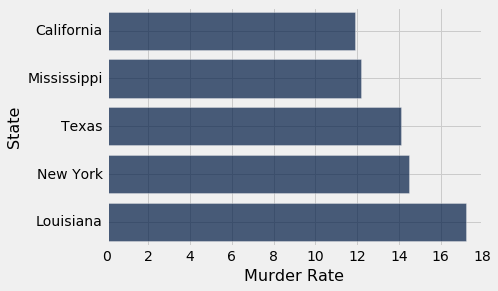

In [6]:
def most_murderous(year):
# Fill in this line so that the next 2 lines do what the function
# is supposed to do.  most should be a table.
    most = murder_rates.where("Year", year).sort('Murder Rate',descending = True).take(range(0,5)).sort("Murder Rate")
    most.barh('State', 'Murder Rate')
    return list(most.column('State'))

most_murderous(1990)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



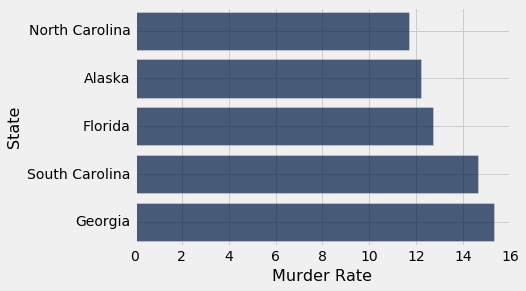

In [7]:
_ = project3.grade("q13")

**Question 1.4.** How many more people were murdered in California in 1988 than in 1975? Assign `ca_change` to the answer.

In [8]:
ca = murder_rates.where('State', 'California')
ca_change = 
np.round(ca_change)

SyntaxError: invalid syntax (<ipython-input-8-ec0aeee48da7>, line 2)

In [ ]:
_ = project3.grade("q14")

# 2. Changes in Murder Rates

Murder rates vary widely across states and years, presumably due to the vast array of differences among states and across US history. Rather than attempting to analyze rates themselves, we will restrict our analysis to whether or not murder rates increased or decreased over certain time spans. We will not concern ourselves with how much rates increased or decreased; only the direction of the change.

The `np.diff` function takes an array of values and computes the differences between adjacent items of a list or array. Instead, we may wish to compute the difference between items that are two positions apart. For example, given a 5-element array, we may want:

    [item 2 - item 0 , item 3 - item 1 , item 4 - item 2]
    
The `diff_n` function below computes this result. Don't worry if the implementation doesn't make sense to you, as long as you understand its behavior.

In [10]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n([1, 10, 100, 1000, 10000], 2)

array([  99,  990, 9900])

**Question 2.1.** Implement the function `two_year_changes` that takes a list of murder rates for a state, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns the number of increases minus the number of decreases.

For example, the rates `r = [10, 7, 12, 9, 13, 9, 11]` contain three increases (10 to 12, 7 to 9, and 12 to 13), one decrease (13 to 11), and one change that is neither an increase or decrease (9 to 9). Therefore, `two_year_changes(r)` would return 2, the difference between three increases and 1 decrease.

In [11]:
def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    def remove_values_from_list(the_list, val):
       return [value for value in the_list if value != val]
    frequencies = remove_values_from_list(diff_n(rates, 2), 0)
    onlyPositives = len([x for x in frequencies if x > 0])
    onlyNegative = len([x for x in frequencies if x < 0])
    return onlyPositives - onlyNegative
        
print('Alaska:',    two_year_changes(ak.column('Alaska')))
print('Minnesota:', two_year_changes(mn.column('Minnesota')))



Alaska: -5
Minnesota: 6


In [ ]:
_ = project3.grade("q21")

We can use `two_year_changes` to summarize whether rates are mostly increasing or decreasing over time for some state or group of states. Let's see how it varies across the 50 US states.

**Question 2.2.** Assign `changes_by_state` to a table with one row per state that has two columns: the `State` name and the `Murder Rate two_year_changes` statistic computed across all years in our data set for that state.  Its first 2 rows should look like this:

|State|Murder Rate two_year_changes|
|-|-|
|Alabama|-6|
|Alaska|-5||


In [ ]:

#changes_by_state.hist(1, bins=np.arange(-11, 12, 2))

In [51]:
# (by grouping murder_rates by state and then grabbing that column 
#then used a for loop to run the function for each element in that array.

#     murderarray = murder_rates.select([0,3]).take(np.arange(i,i+44)).apply(two_year_changes,"Murder Rate")

# i = 0
# while  (i+44) < 2200:             
#     two_year_changes(murder_rates.select([0,3]).take(np.arange(i,i+44)).column(1)))
#     i = i + 44 
    
murder_rates.select([0,3]).take(np.arange(0,0+44)).apply(two_year_changes, "Murder Rate")
# changes_by_state = Table().with_column([
#         'State', murder_rates.sort("State").group(0).select(0),
#         'Murder Rate two_year_changes', a
#     ])


AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
_ = project3.grade("q22")

Some states have more increases than decreases (a positive number), while some have more decreases than increases (a negative number). 

**Question 2.3.** Assign `total_changes` to the total increases minus the total decreases for all two-year periods and all states in our data set.

In [ ]:
total_changes = 
print('Total increases minus total decreases, across all states and years:', total_changes)

"More increases than decreases," one student exclaims, "Murder rates tend to go up across two-year periods. What dire times we live in."

"Not so fast," another student replies, "Even if murder rates just moved up and down uniformly at random, there would be some difference between the increases and decreases. Perhaps this difference we observed is a typical value when so many changes are observed if the state murder rates increase and decrease at random!"

**Question 2.4.** Set `num_changes` to the number of different two-year periods in the entire data set that could result in a change of a state's murder rate. Include both those periods where a change occurred and the periods where a state's rate happened to stay the same.

In [ ]:
num_changes = ...
num_changes

In [ ]:
_ = project3.grade("q24")

We now have enough information to perform a hypothesis test, using the difference between increases and decreases as a test statistic.

> **Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution.

*Technical note*: These changes in murder rates are not random samples from any population. They describe all murders in all states over all recent years. However, we can imagine that history could have been different, and that the observed changes are the values observed in only one possible world: the one that happened to occur. In this sense, we can evaluate whether the observed "total increases minus total decreases" is consistent with a hypothesis that increases and decreases are drawn at random from a uniform distribution.

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way.

In [52]:
uniform = Table(['Change', 'Chance']).with_rows([['Increase', 0.5], ['Decrease', 0.5]])
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,53
Decrease,0.5,47


**Question 2.5.** Complete the simulation below, which samples `num_changes` increases/decrease at random many times in order to form an empirical distribution of the difference between increases and decreases under the null hypothesis. The `uniform_samples` table should contain one row for each repetition that contains the difference between increases and decreases.

In [ ]:
uniform_samples = Table(['Increases minus decreases'])
for i in np.arange(5000):
    sample = ...
    ...
uniform_samples.hist(0, bins=np.arange(-200, 201, 25))

In [ ]:
_ = project3.grade("q25")

**Question 2.6.** Looking at this histogram, draw a conclusion about whether murder rates systematically increase more than they decrease, or whether the difference is consistent with the null hypothesis. (You *do not* need to compute a P-value for this question.)

*Write your conclusion here, replacing this text.*

# 3. The death penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the death penalty affects the murder rate of a state.

**Question 3.1.** Describe this investigation in terms of an experiment. What population are we studying? What is the control group? What is the treatment group? What outcome are we measuring?

*Write your answers below.*

- Population: ...
- Control Group: ...
- Treatment Group: ...
- Outcome: ...

**Question 3.2.** We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

*Write your answer here, replacing this text.*

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we can reasonably expect that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.  

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in the year after 1972.

> **Control group:** The states in that population, in the year before 1972.

> **Null hypothesis:** Each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period.  (Whether the murder rate increased or decreased in each state was like the flip of a fair coin.)

> **Alternative hypothesis:** The murder rate was more likely to increase *or* more likely to decrease.

*Technical Note:* It's not clear that the murder rates were a "sample" from any larger population.  Again, it's useful to imagine that our data could have come out differently and to test the null hypothesis that the murder rates were equally likely to move up or down.

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

In [ ]:
def had_death_penalty_in_1971(state):
    return state not in ['Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota']

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

In [ ]:
num_death_penalty_states = death_penalty.where(1, True).num_rows
num_death_penalty_states

**Question 3.3.** Assign `death_penalty_murder_rates` to a table with the same columns and data as `murder_rates`, but that has only the rows for states that had the death penalty in 1971.

In [ ]:
death_penalty_murder_rates = ...
death_penalty_murder_rates

In [ ]:
_ = project3.grade("q33")

The null hypothesis doesn't specify *how* the murder rate changes; it only talks about increasing or decreasing.  So, again we will use a test statistic that measures the difference between the number of increases and decreases to evaluate the null hypothesis.

> **Test statistic:** For a collection of states and two years, compute the number of states where the murder rate increased, then subtract the number of states where the murder rate decreased.

A hypothesis test with this kind of statistic is called a *sign test*, since it only looks at the sign of a change.  If the test statistic is very large (or very small), that means many more (or many fewer) states saw increases in murder rates than decreases. Values near 0 are consistent with the null hypothesis, and large positive or negative values are inconsistent.

**Question 3.4.** Complete the function called `sign_test_statistic` by implementing `increases_minus_decreases`. The `sign_test_statistic` function takes 3 arguments:
* `table`, a table,
* `before`, the label of a column of numbers in that table containing rates at the start of the two-year period, and
* `after`, the label of another column of numbers in that table containing rates at the end of the two-year period.

It should return the number of rows in which the `after` column has a higher value than the `before` column, minus the number of rows in which the `before` column has a higher value than the `after` column.  In other words, it computes our test statistic.

In [ ]:
# This function is written for you, except that it relies on the
# function increases_minus_decreases, which we have left for you
# to finish.
def sign_test_statistic(table, before, after):
    """The number of increases minus the number of decreases, for all rows in table."""
    before_column = table.column(before)
    after_column = table.column(after)
    return increases_minus_decreases(before_column, after_column)

def increases_minus_decreases(before_column, after_column):
    """The number of increases minus the number of decreases between two parallel arrays."""
    assert len(before_column < after_column) == len(before_column) == len(after_column), 'Bad arguments'
    # Fill in this function starting here.
    ...

In [ ]:
_ = project3.grade("q34")

**Question 3.5.** Assign `changes_72` to the value of our test statistic for the years 1971 to 1973 and the states in `death_penalty_murder_rates`.

In [ ]:
compare_72 = Table().with_columns([
        ...
        ...
        ])

changes_72 = sign_test_statistic(compare_72, '1971', '1973')
print('Increases minus decreases from 1971 to 1973:', changes_72)

In [ ]:
_ = project3.grade("q35")

**Question 3.6.** Write a function called `simulate_statistic_under_null`.  It should take as its argument a sample size `n` (such as the number of death penalty states in 1971).  It should simulate one sample of `n` states' murder rate changes *under the null hypothesis* and return the *number* of increases minus the number of decreases in that sample.  In other words, it should simulate one value of `sign_test_statistic` that we'd see if the null hypothesis were true.  That value should be an integer between `-n` and `n` (inclusive).

In [ ]:
def simulate_statistic_under_null(n):
    sample = ...
    ...

simulate_statistic_under_null(10)

In [ ]:
_ = project3.grade("q36")

**Question 3.7.**: Draw an empirical histogram of the statistic under the null hypothesis by simulating the test statistic 5000 times.

In [ ]:
samples = Table(['Test statistic under null'])
for i in np.arange(5000):
    ...
samples.hist(0)

In [ ]:
_ = project3.grade("q37")

### Conclusion

To complete our analysis, we can compare this empirical distribution to the observed test statistic for the two-year period from 1971 to 1973.

The P-value of the observation is the proportion of simulated test statistics that are at least as extreme as the observed value. Either a very positive or a very negative observation is inconsistent with this empirical distribution.  In this case, we include in the P-value proportion all simulated statistics that are as least as large as `changes_72` or at least as small as `-changes_72` (that's negative one times `changes_72`). Including both positive and negative extremes in the P-value proportion is called a *two-tailed* test.

**Question 3.8.**  Assign `sign_72_p_value` to the two-tailed P-value of the observed `changes_72` under the null hypothesis.

In [ ]:
sign_72_p_value = ...
print('1971 - 1973 P-value:', sign_72_p_value)

**Question 3.9.** Draw an inferential conclusion about the changes in murder rates from 1971 to 1973 in states where the death penalty was originally in force.

*Write your conclusion here, replacing this text.*

# 4. Further evidence

So far, we have discovered evidence that when executions were outlawed, the murder rate increased in many more states than we would expect from random chance. We have also seen that across all states and all recent years, the murder rate goes up about as much as it goes down over two-year periods. 

These discoveries seem to support the claim that eliminating the death penalty increases the murder rate. Should we be convinced? Let's conduct some more sign tests to strengthen our claim.

Conducting a sign test for this data set required the following steps:

1. Select a table containing murder rates for certain states and all years,
2. Choose two years and compute the observed difference between increases and decreases,
3. Simulate the test statistic under the null hypothesis that increases and decreases are drawn uniformly at random, then
4. Compare the observed difference to the empirical distribution to compute a two-tailed P-value.

This entire process can be expressed in a single function, called `sign_test`.

**Question 4.1.** Implement `sign_test`, which takes the following arguments:

- A table of murder `rates` for certain states, and
- A `before` year and an `after` year.

It prints out the observed test statistic and returns the P-value for this statistic under the null hypothesis.

*Hint*: You can use functions you already defined, such as `increases_minus_decreases` and `simulate_statistic_under_null`.

In [ ]:
def sign_test(rates, before, after):
    """Return a two-tailed P-value for the observed difference between increases and decreases."""
    changes = ...
    print('Increases minus decreases', before, 'to', after, ':', changes)
    num_states = rates.group('State').num_rows
    
    samples = Table(['Test statistic under null'])
    for i in np.arange(5000):
        ...
    ...
    
sign_test(death_penalty_murder_rates, 1971, 1973)

In [ ]:
_ = project3.grade("q41")

### The rest of the states

We found a dramatic increase in murder rates for those states affected by the 1972 Supreme Court ruling, but what about the rest of the states? There were six states that had already outlawed execution at the time of the ruling.

**Question 4.2.** Create a table called `non_death_penalty_murder_rates` with the same columns as `murder_rates` but only containing rows for the six states without the death penalty in 1971. Perform the same sign test on this table. In one sentence, conclude whether their murder rates also increased from 1971 to 1973.

In [ ]:
non_death_penalty_murder_rates = ...
sign_test(non_death_penalty_murder_rates, 1971, 1973)

*Write your conclusion here, replacing this line.*

In [ ]:
_ = project3.grade("q42")

### The death penalty reinstated

In 1976, the Supreme Court repealed its ban on the death penalty in its rulings for [a series of cases including Gregg v. Georgia](https://en.wikipedia.org/wiki/Gregg_v._Georgia), so the death penalty was reinstated where it was previously banned.  This generated a second natural experiment.  To the extent that the death penalty deters murder, reinstating it should decrease murder rates, just as banning it should increase them. Let's see what happened.

In [ ]:
sign_test(death_penalty_murder_rates, 1975, 1977)

*Hint:* You should see above an observed statistic of -18; there were 18 more decreases than increases among the 44 states that had the death penalties in force. You should also have found a P-value near 0.01. If your P-value is very different, go back and inspect your `sign_test` implementation to make sure that it correctly handles negative observed test statistics.

**Question 4.3.** Now we've analyzed states where the death penalty went away and came back, as well as states where the death penalty was outlawed all along.  What do you conclude from  the results of the tests we have conducted so far? Is all the evidence consistent, or is there a contradiction?

*Write your answer here, replacing this text.*

## 5. Visualization

While our analysis appears to support the conclusion that the death penalty deters murder, [a 2006 Stanford Law Review paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf) argues the opposite: that historical murder rates do **not** provide evidence that the death penalty deters murderers.

To understand their argument, we will draw a picture.  In fact, we've gone at this whole analysis rather backward; typically we should draw a picture first and ask precise statistical questions later!

What plot should we draw?

We know that we want to compare murder rates of states with and without the death penalty.  We know we should focus on the period around the two natural experiments of 1972 and 1976, and we want to understand the evolution of murder rates over time for those groups of states.  It might be useful to look at other time periods, so let's plot them all for good measure.

**Question 5.1.** Create a table called `average_murder_rates` with 1 row for each year in `murder_rates`.  It should have 3 columns:
* `Year`, the year,
* `Death penalty states`, the average murder rate of the states that had the death penalty in 1971, and
* `No death penalty states`, the average murder rate of the other states.

`average_murder_rates` should be sorted in increasing order by year.  Its first three rows should look like:

|Year|Death penalty states|No death penalty states|
|-|-|-|
|1960| | |
|1961| | |
|1962| | ||

*Hint:*  Use `pivot`. To compute average murder rates across states, just average the murder rates; you do not need to account for differences in population.

In [ ]:
average_murder_rates = ...
average_murder_rates

In [ ]:
_ = project3.grade("q51")

**Question 5.2.** Describe in **one short sentence** a high-level takeaway from the line plot below. Are the murder rates in these two groups of states related?

In [ ]:
average_murder_rates.plot('Year')

*Write your answer here, replacing this text.*

Let's bring in another source of information: Canada.

In [ ]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select(["Year", "Homicide"]).relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

The line plot we generated above is similar to a figure from the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

<img src="paper_plot.png"/>

Canada has not executed a criminal since 1962. Since 1967, the only crime that can be punished by execution in Canada is the murder of on-duty law enforcement personnel. The paper states, "The most striking finding is that the homicide rate in Canada has moved in
virtual lockstep with the rate in the United States."

**Question 5.4.** Complete their argument in 2-3 sentences; what features of these plots indicate that the death penalty is not an important factor in determining the murder rate? (If you're stuck, read the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).)

*Write your answer here, replacing this text.*

**Question 5.5.** What assumption(s) did we make in Parts 1 through 4 of the project that led us to believe that the death penalty deterred murder, when in fact the line plots tell a different story?

*Write your answer here, replacing this text.*

**You're done! Congratulations.**

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [project3.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")